In [2]:
import torch
import torchvision

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.1
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

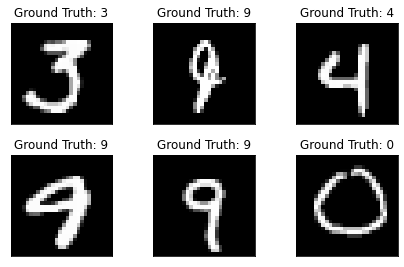

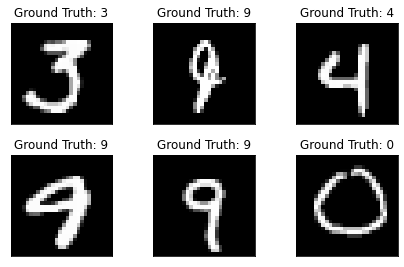

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [10]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\larsr\AppData\Local\Temp\ipykernel_15312\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\larsr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.174963
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.743945
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.208128
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.080667
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.026801
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.922626
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.965408
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.765493
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.840260
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.801945
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.601371
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.691843
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.409482
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.738920
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.561783
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.505545
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.533023
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.493985
Train Epoch: 1 [12160/6

In [15]:
with torch.no_grad():
  output = network(example_data)

C:\Users\larsr\AppData\Local\Temp\ipykernel_15312\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [16]:
example_data[0].shape

torch.Size([1, 28, 28])

In [20]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [22]:
network_state_dict = torch.load('results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [23]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

C:\Users\larsr\AppData\Local\Temp\ipykernel_15312\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.227031
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.231237
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.643486
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.198424
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.184931
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.168506
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.192944
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.374011
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.079906
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.175436
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.128974
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.506981
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.230067
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.161784
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.366956
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.341689
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.205574
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.349226
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.193729
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.151332
Train Epoch: 4 [12800/60000 (

c:\Users\larsr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0715, Accuracy: 9787/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.317842
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.119863
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.122879
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.306263
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.102757
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.224681
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.259232
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.258134
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.161883
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.051458
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.353832
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.326918
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.160144
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.261883
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.326879
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.207596
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.444574
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.187769
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.218442
Train Epoch: 5 [12160

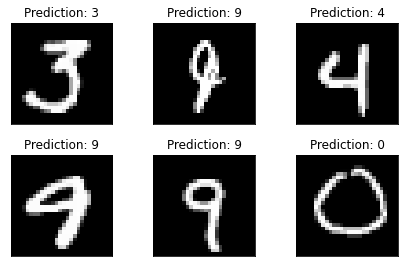

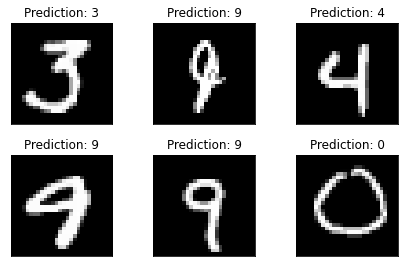

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [19]:
# Load model

import torch
from PIL import Image

predicter = Net()
network_state_dict = torch.load('results/model.pth')
predicter.load_state_dict(network_state_dict)


image = Image.open('puzzles/2/cell_04.png')




FileNotFoundError: [Errno 2] No such file or directory: 'puzzles/2/cell_04.png'

In [ ]:
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
loader = transforms.Compose([transforms.Resize(28), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

1


C:\Users\larsr\AppData\Local\Temp\ipykernel_22216\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


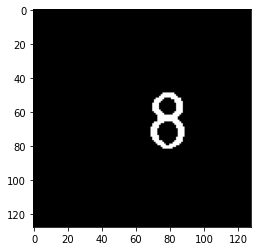

In [ ]:
# Disable grad
with torch.no_grad():

  image = Image.open('puzzles/2/cell_30.png')

  # Show result
  plt.imshow(image, cmap='gray')

  # Loading the saved model
  model = Net()
  model.load_state_dict(torch.load("results/model.pth"))
  model.eval()

  # Generate prediction
  input = loader(image)
  # input = input.view(1, 28, 28)

  prediction = model(input)

  # Predicted class value using argmax
  predicted_class = int(np.argmax(prediction))

  print(predicted_class)